# Linear Interpolation (LI) - locally self-adaptive approach

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import random
import torch

## Establish parameters

In [2]:
# Generate VRPs for each sub-area
resolution = 2  # Define the spacing between the generated points --> Change depending on demand

# Number of neighbors for the GPR
k_neighbors = 40

In [3]:
import time
start_time = time.time()

In [4]:
def set_seed(seed):
    """
    Set random seed for reproducibility.
    - seed: Integer seed value.
    """
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed
    torch.manual_seed(seed)
    
    # If using CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Ensure deterministic behavior in PyTorch (slight impact on performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed before training

set_seed(42)

# Data to be used

In [5]:
# Path to the data
# data_path = "C:/Users/Maria Lao/Documents/Universidad/UOC/TFM/3 - Datasets/WIFI/"
data_path = "/kaggle/input/wifi-dataset-tfm/"

train_coords_file = data_path + "DSI1_trncrd.csv"
test_coords_file = data_path + "DSI1_tstcrd.csv"

train_clean_file = data_path + "DSI1_trnrss_clean.csv"
test_clean_file = data_path + "DSI1_tstrss_clean.csv"

In [6]:
train_coords = pd.read_csv(train_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
train_rss = pd.read_csv(train_clean_file, header=None)
test_coords = pd.read_csv(test_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
test_rss = pd.read_csv(test_clean_file, header=None)

In [7]:
train_coords_2 = pd.read_csv(train_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
train_rss_2 = pd.read_csv(train_clean_file, header=None)
test_coords_2 = pd.read_csv(test_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
test_rss_2 = pd.read_csv(test_clean_file, header=None)

In [8]:
# Initial exploration
print("Train Coordinates Shape:", train_coords.shape)
print("Train RSS Shape:", train_rss.shape)
print("Test Coordinates Shape:", test_coords.shape)
print("Test RSS Shape:", test_rss.shape)

Train Coordinates Shape: (1369, 5)
Train RSS Shape: (1369, 157)
Test Coordinates Shape: (348, 5)
Test RSS Shape: (348, 157)


##  Virtual Reference Points

In [9]:
# Function to calculate the bandwidth using Silverman's rule
def silverman_bandwidth(data):
    n, d = data.shape  # n: number of points, d: dimension
    std_dev = np.std(data, axis=0).mean()  # Average of standard deviations across all dimensions
    return (4 / (d + 2))**(1 / (d + 4)) * std_dev * n**(-1 / (d + 4))

In [10]:
# Load the coordinates and select only x and y
data_train_coords = train_coords[["x", "y"]].to_numpy()

In [11]:
# Bandwidth calculation using Silverman's rule
bandwidth = silverman_bandwidth(data_train_coords)
print(f"Bandwidth compted using Silverman: {bandwidth}")

# Clustering using Mean Shift
mean_shift = MeanShift(bandwidth=bandwidth)
labels = mean_shift.fit_predict(data_train_coords)

# Identify sub-areas
unique_labels = np.unique(labels)
sub_areas = [data_train_coords[labels == label] for label in unique_labels]

Bandwidth compted using Silverman: 6.895746070407274


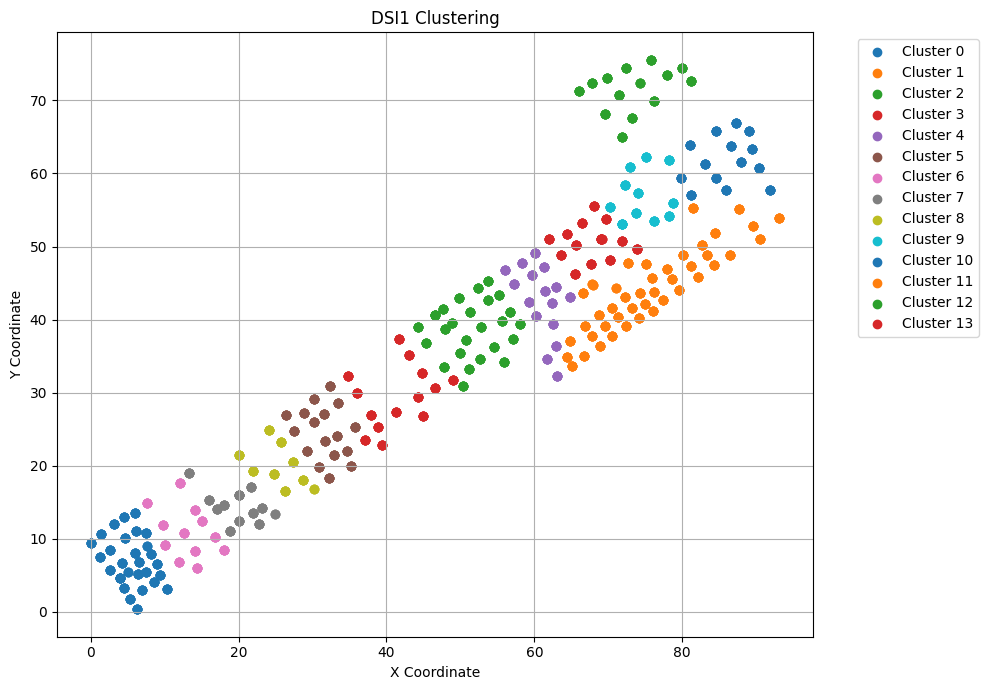

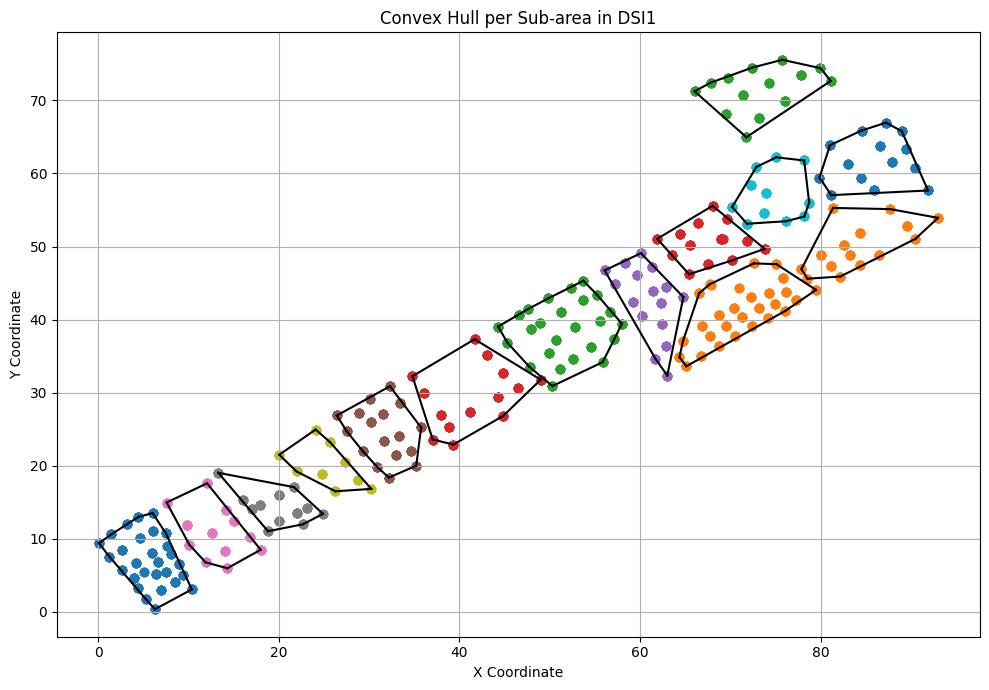

In [12]:
# Plot initial 
plt.figure(figsize=(10, 7))
for i, area in enumerate(sub_areas):
    plt.scatter(area[:, 0], area[:, 1], label=f'Cluster {i}')
plt.title("DSI1 Clustering")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.grid()
plt.show()

# Plot Convex Hulls
plt.figure(figsize=(10, 7))
for area in sub_areas:
    if len(area) >= 3:
        hull = ConvexHull(area)
        plt.scatter(area[:, 0], area[:, 1])
        for simplex in hull.simplices:
            plt.plot(area[simplex, 0], area[simplex, 1], 'k-')
plt.title("Convex Hull per Sub-area in DSI1")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.tight_layout()
plt.grid()
plt.show()


In [13]:
from matplotlib.path import Path

# Function to generate VRPs within the Convex Hull
def generate_vrps(area, resolution=1):
    """
    Generates uniformly distributed virtual points (VRPs) within a Convex Hull.
    :param area: Coordinates of the sub-area (numpy array of Nx2).
    :param resolution: Spacing between the points in the grid (same units as x, y).
    :return: Numpy array with the generated VRPs.
    """
    # Create a uniform grid within the bounds of the area
    x_min, y_min = area.min(axis=0)
    x_max, y_max = area.max(axis=0)
    x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, resolution), 
                                 np.arange(y_min, y_max, resolution))
    grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]
    
    # Filter points inside the Convex Hull
    hull_path = Path(area[ConvexHull(area).vertices])  # Create polygon from the hull
    vrps = grid_points[hull_path.contains_points(grid_points)]
    
    return vrps

# Generate VRPs for each sub-area
vrp_clusters = []  # List to store VRPs for all sub-areas


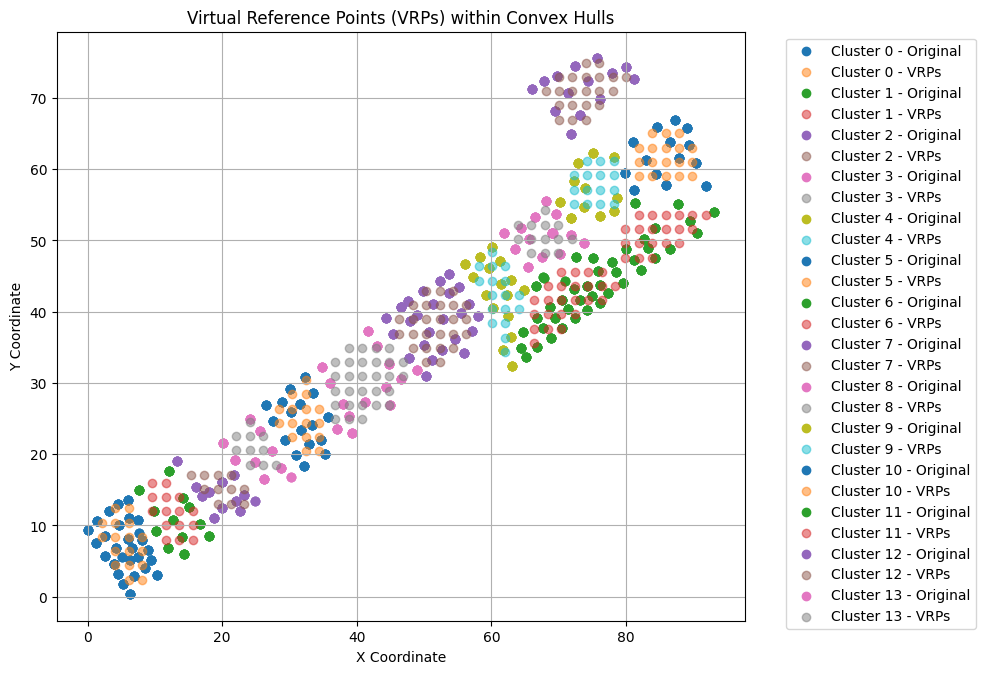

In [14]:
plt.figure(figsize=(10, 7))
for i, area in enumerate(sub_areas):
    if len(area) >= 3:
        # Generate VRPs for the sub-area
        vrps = generate_vrps(area, resolution=resolution)
        vrp_clusters.append(vrps)
        
        # Visualize original points and VRPs
        plt.scatter(area[:, 0], area[:, 1], label=f"Cluster {i} - Original")
        plt.scatter(vrps[:, 0], vrps[:, 1], alpha=0.5, label=f"Cluster {i} - VRPs")

plt.title("Virtual Reference Points (VRPs) within Convex Hulls")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()


In [15]:
# Count original points
original_points_count = sum(len(area) for area in sub_areas)

# Count generated VRPs
vrp_points_count = sum(len(vrps) for vrps in vrp_clusters)

# Calculate the percentage increase
increment_percentage = (vrp_points_count / original_points_count) * 100

# Print results
print(f"Original RPs: {original_points_count}")
print(f"Generated VRPs: {vrp_points_count}")
print(f"Increment in RPs: {increment_percentage:.2f}%")
print(f"Total RPs (Original + VRPs): {original_points_count + vrp_points_count:.2f}")

Original RPs: 1369
Generated VRPs: 252
Increment in RPs: 18.41%
Total RPs (Original + VRPs): 1621.00


In [16]:
# Prepare prediction data for GPR (VRP coordinates)
X_pred = np.vstack(vrp_clusters)  # Coordinates of VRPs


# Extract unique constant values from train_coords
z_value = train_coords["z"].unique()[0]        # Unique z value
floor_value = train_coords["floor"].unique()[0]  # Unique floor value
building_value = train_coords["building"].unique()[0]  # Unique building value

# Add these columns to VRPs
vrp_augmented = np.hstack([
    X_pred,  # x, y from VRPs
    np.full((X_pred.shape[0], 1), z_value),        # z column
    np.full((X_pred.shape[0], 1), floor_value),    # floor column
    np.full((X_pred.shape[0], 1), building_value)
])

print(f"Shape of augmented VRPs with additional columns: {vrp_augmented.shape}")


Shape of augmented VRPs with additional columns: (252, 5)


## Gaussian Process Regression (GPR)

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ConstantKernel, RBF
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree

In [18]:
# Replace invalid RSS values (100) with NaN
train_rss.replace(100, np.nan, inplace=True)
test_rss.replace(100, np.nan, inplace=True)

# Automatically calculate RSS_MIN and RSS_MAX, ignoring NaN values
RSS_MIN = train_rss.min().min()  # Minimum valid RSS value
RSS_MAX = train_rss.max().max()  # Maximum valid RSS value

# Replace NaN with a neutral value (e.g., RSS_MIN - 20)
neutral_value = RSS_MIN - 20
train_rss.fillna(neutral_value, inplace=True)
test_rss.fillna(neutral_value, inplace=True)

In [19]:
# Function to normalize RSS values
def normalize_rss(rss_matrix, rssi_min, rssi_max):
    """
    Normalize RSS values to the range [0, 1], ensuring NaN handling is safe.
    """
    rss_normalized = (rssi_max - rss_matrix) / (rssi_max - rssi_min)
    rss_normalized = rss_normalized.clip(0, 1)  # Ensure all values are in [0, 1]
    return rss_normalized

def denormalize_rss(rss_normalized, rssi_min, rssi_max):
    """
    Denormalize RSS values from the range [0, 1] back to their original scale.
    """
    rss_matrix = rssi_max - (rss_normalized * (rssi_max - rssi_min))
    return rss_matrix

In [20]:
# Normalize RSS data
train_rss_normalized = normalize_rss(train_rss.values, RSS_MIN, RSS_MAX)
test_rss_normalized = normalize_rss(test_rss.values, RSS_MIN, RSS_MAX)

train_coords_np = train_coords[['x', 'y', 'z']].to_numpy()

In [21]:
import warnings
warnings.filterwarnings("ignore")


# Build a KDTree for fast neighbor search
tree = cKDTree(train_coords)


# Define a kernel with adjusted parameter bounds
# kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
#          RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-2, 1e2), alpha_bounds=(1e-2, 1e2))

# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) 
kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 50.0))

# Initialize the Gaussian Process Regressor with more optimization iterations
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=10)

# Predict RSS values for VRPs using local GPR with k-nearest neighbors
print(f"Predicting RSS values for VRPs using {k_neighbors} nearest neighbors...")
vrp_rss_scaled = []

for vrp in vrp_augmented:
    # Find k-nearest neighbors for the current VRP
    distances, indices = tree.query(vrp, k=k_neighbors)
    X_neighbors = train_coords_np[indices]
    y_neighbors = train_rss_normalized[indices]

    # Train GPR on local data
    gpr.fit(X_neighbors, y_neighbors)

    # Predict RSS for the current VRP
    vrp_selected = vrp[:3]  # Selecciona las primeras 3 columnas
    vrp_rss_scaled.append(gpr.predict([vrp_selected])[0])

print(f"RSS generated in the VRPs")

Predicting RSS values for VRPs using 40 nearest neighbors...
RSS generated in the VRPs


In [22]:
# Convert VRP RSS predictions to numpy array
vrp_rss_normalized = np.array(vrp_rss_scaled)

# Inverse transform the scaled RSS predictions back to original scale
vrp_rss = denormalize_rss(vrp_rss_normalized, RSS_MIN, RSS_MAX) 
# Summary
print(f"RSS generated in the VRPs: {vrp_rss.shape}")
print(f"VRPs dataframe: {vrp_augmented.shape}")

RSS generated in the VRPs: (252, 157)
VRPs dataframe: (252, 5)


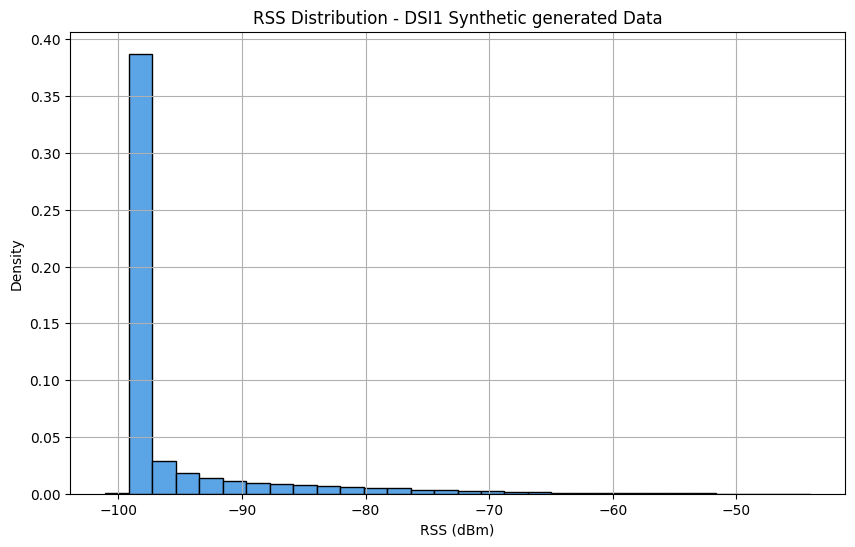

Remaining values after filtering: 39564
Are there any values equal to -119.0 ?: False


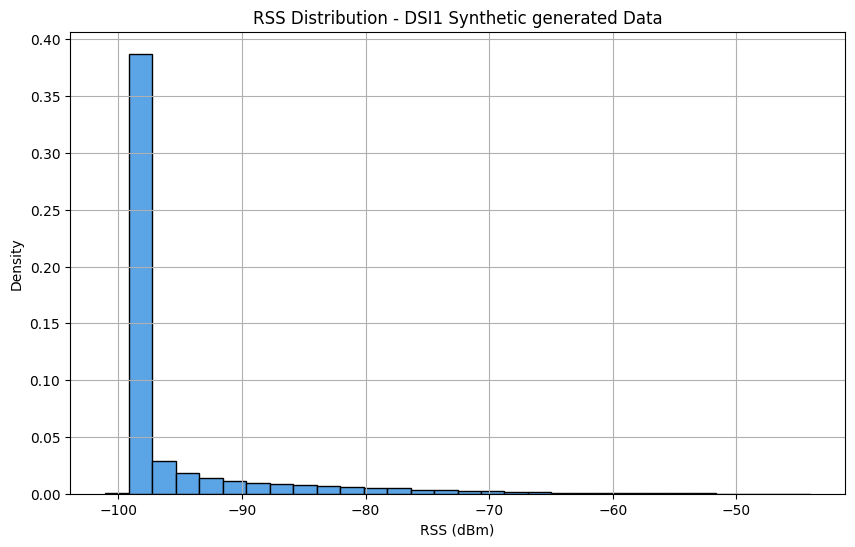

In [23]:
# Function to plot RSS distribution for each dataset
def plot_rss_distribution(data, title, dataset_name):
    """
    Plots a histogram of RSS values.
    :param data: numpy array of RSS values.
    :param title: Title for the plot.
    :param dataset_name: Dataset name for labeling the plot.
    """
    # Flatten the data to ensure it's 1D
    data_flat = data.flatten()
    
    # Plot the histogram if there are valid RSS values
    if data_flat.size > 0:
        plt.figure(figsize=(10, 6))
        plt.hist(data_flat, bins=30, edgecolor='black', density=True, color='#5ba4e5')  # Light pastel blue
        plt.title(f"RSS Distribution - {dataset_name} {title}")
        plt.xlabel("RSS (dBm)")
        plt.ylabel("Density")
        plt.grid(True)
        plt.show()
    else:
        print(f"No valid RSS values found for {title}")

# Function to plot RSS distribution ignoring invalid values
def plot_rss_distribution_filter(data, title, dataset_name, neutral_value):
    """
    Plots a histogram of RSS values, ignoring invalid values (e.g., -120).
    :param data: numpy array of RSS values.
    :param title: Title for the plot.
    :param dataset_name: Dataset name for labeling the plot.
    :neutral_value: value to ignore
    """
    # Filter values close to neutral_value with a small tolerance
    data_filtered = data.flatten()[~np.isclose(data.flatten(), neutral_value, atol=1e-6)]
    
    # Debugging: Check if the filter works properly
    print(f"Remaining values after filtering: {data_filtered.size}")
    print(f"Are there any values equal to {neutral_value} ?: {(neutral_value in data_filtered)}")

    # Plot the histogram if valid values exist
    if data_filtered.size > 0:
        plt.figure(figsize=(10, 6))
        plt.hist(data_filtered, bins=30, edgecolor='black', density=True, color='#5ba4e5')  # Light pastel blue
        plt.title(f"RSS Distribution - {dataset_name} {title}")
        plt.xlabel("RSS (dBm)")
        plt.ylabel("Density")
        plt.grid(True)
        plt.show()
    else:
        print(f"No valid RSS values found for {title}")



# Call the functions for synthetic data
plot_rss_distribution(vrp_rss, "Synthetic generated Data", "DSI1")
plot_rss_distribution_filter(vrp_rss, "Synthetic generated Data", "DSI1", neutral_value)



In [24]:
print (neutral_value)

-119.0


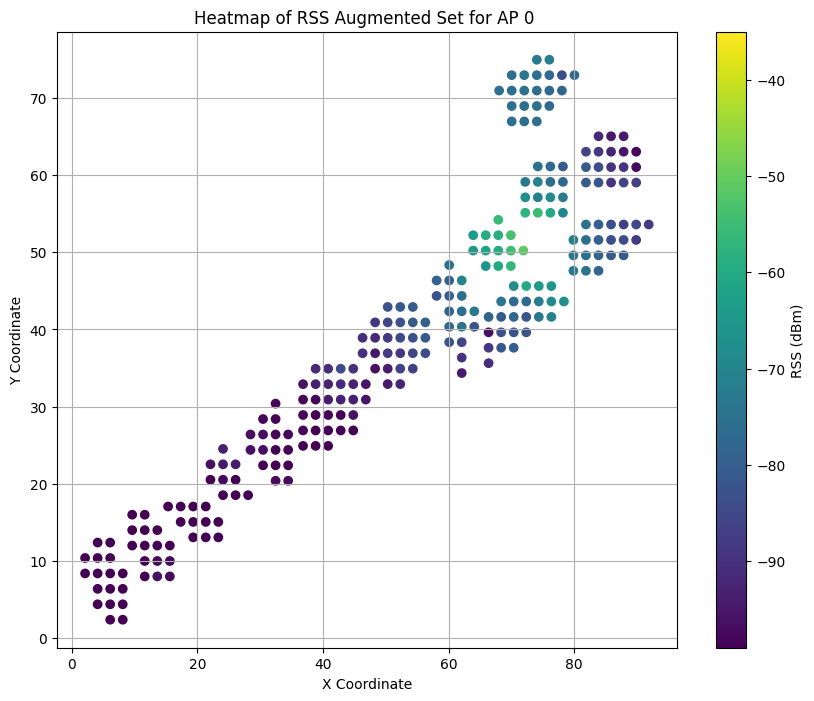

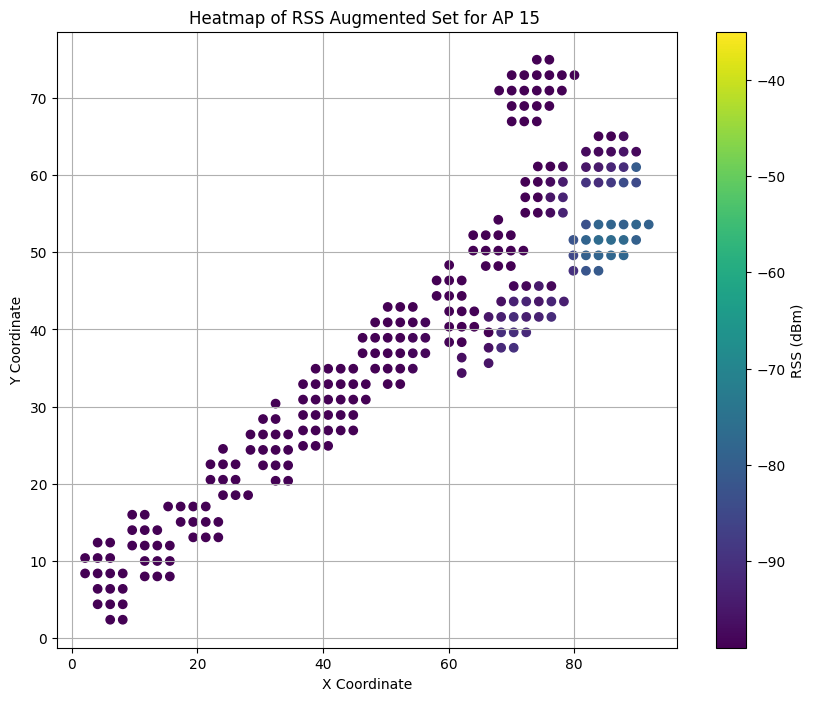

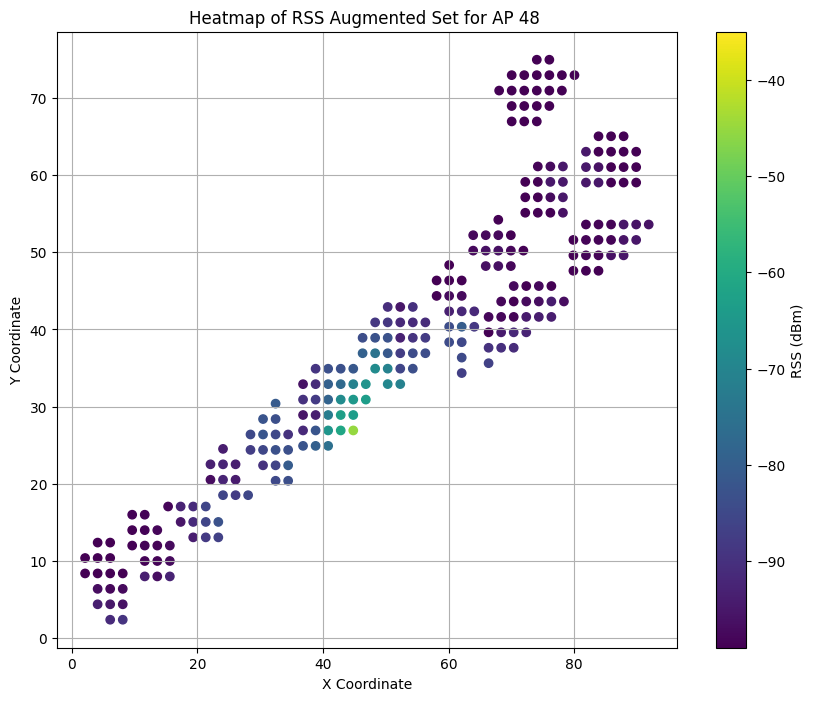

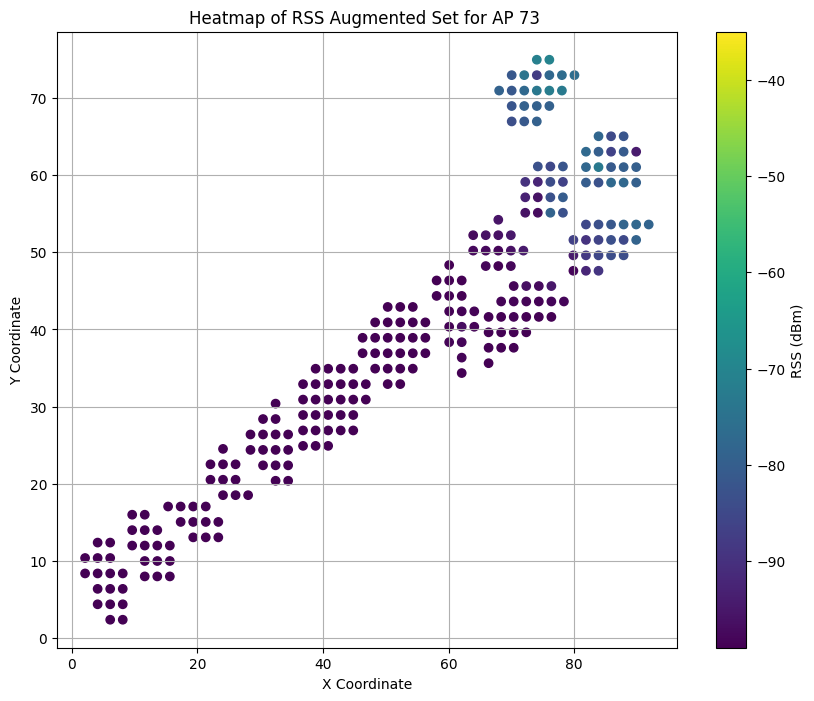

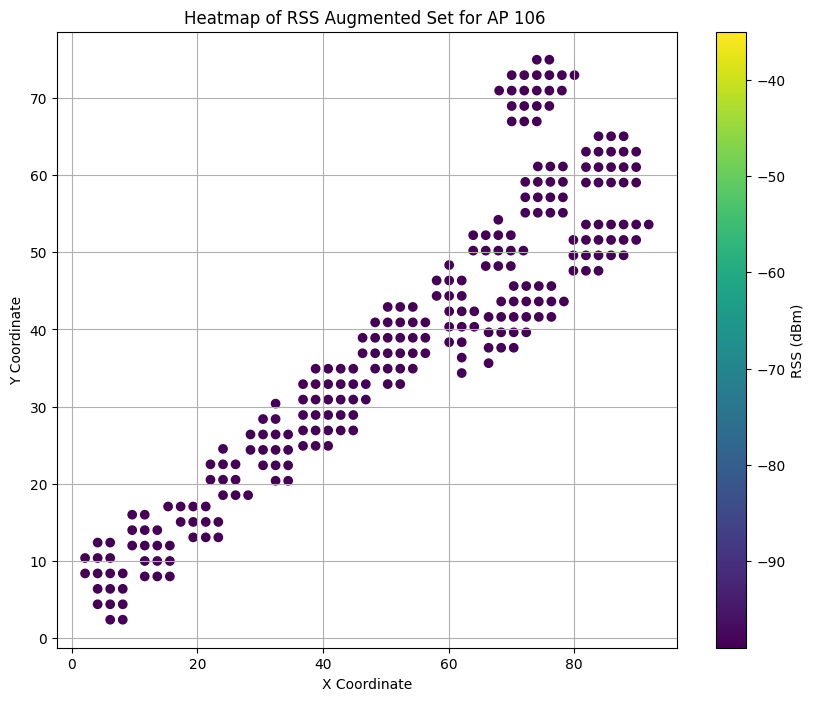

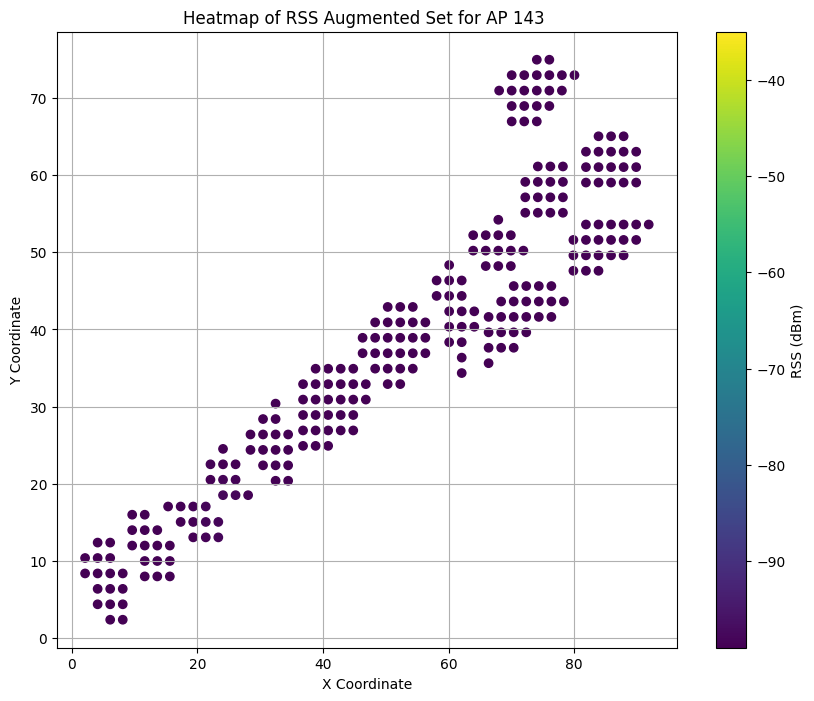

In [25]:
# Function to plot a heatmap for a specific AP
def plot_rss_heatmap(coords, rss, ap_index, title, null_value=100):
    """
    Plots a heatmap where color intensity represents the RSS value for a specific AP.

    Parameters:
        coords (DataFrame or ndarray): DataFrame with coordinates (x, y) or ndarray.
        rss (DataFrame or ndarray): DataFrame or ndarray with RSS values for each AP.
        ap_index (int): Index of the AP to plot.
        title (str): Title of the plot.
        null_value (int): Value representing null RSS measurements (default: 100).
    """
    # Extract the AP's RSS values and replace null values with a neutral value
    if isinstance(rss, pd.DataFrame):  # If RSS is a DataFrame
        ap_rss = rss.iloc[:, ap_index].replace(null_value, neutral_value)
    else:  # If RSS is a Numpy array
        ap_rss = np.where(rss[:, ap_index] == null_value, neutral_value, rss[:, ap_index])

    # Extract x and y coordinates
    if isinstance(coords, pd.DataFrame):  # If coords is a DataFrame
        x = coords["x"]
        y = coords["y"]
    else:  # If coords is a Numpy array
        x = coords[:, 0]
        y = coords[:, 1]

    # Use global RSS_MIN and RSS_MAX for color scale
    vmin = RSS_MIN
    vmax = RSS_MAX

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x, y, c=ap_rss, cmap="viridis", vmin=vmin, vmax=vmax)
    plt.colorbar(scatter, label="RSS (dBm)")
    plt.title(f"Heatmap of RSS {title} for AP {ap_index} ")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

# Example usage
ap_indices = [0, 15, 48, 73, 106, 143] 
for ap_index in ap_indices:
    plot_rss_heatmap(vrp_augmented, vrp_rss, ap_index, title=f"Augmented Set")




In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [27]:
# VAMOS A TRABAJAR EN KNN SIEMPRE CON LOS DATOS NRMALIZADOS

# Prepare training data without augmentation
X_train_orig = train_rss_normalized
y_train_orig = train_coords[['x', 'y', 'z', 'floor', 'building']].to_numpy()

# Prepare training data with augmentation
X_train_aug = np.vstack([X_train_orig, vrp_rss_normalized])        # Combine train_rss and VRP RSS
y_train_aug = np.vstack([y_train_orig, vrp_augmented ])  # Combine train_coords and VRPs

# Prepare test data
X_test = test_rss_normalized
y_test = test_coords[['x', 'y', 'z', 'floor', 'building']].to_numpy()


In [28]:
# Function to perform 5-fold cross-validation and calculate mean MSE
def evaluate_knn(X, y, k_values):
    """
    Evaluates kNN with 5-fold cross-validation for a range of k values.
    :param X: Input features (numpy array)
    :param y: Target labels (numpy array)
    :param k_values: List of k values to evaluate
    :return: Dictionary with k values as keys and mean MSE as values
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = {}

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        fold_mse = []  # Store MSE for each fold

        for train_index, val_index in kf.split(X):
            # Split into training and validation sets
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Train and predict
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)

            # Calculate MSE for the fold
            fold_mse.append(mean_squared_error(y_val, y_pred))

        # Store the mean MSE for the current k
        mse_scores[k] = np.mean(fold_mse)

    return mse_scores

# Define the range of k values to test
k_values = list(range(1, 31))  # Test k from 1 to 30

# Evaluate kNN for the original data
print("Evaluating kNN for original data...")
mse_scores_orig = evaluate_knn(X_train_orig, y_train_orig, k_values)
best_k_orig = min(mse_scores_orig, key=mse_scores_orig.get)
print(f"Optimal k for original data: {best_k_orig}")

# Evaluate kNN for the augmented data
print("Evaluating kNN for augmented data...")
mse_scores_aug = evaluate_knn(X_train_aug, y_train_aug, k_values)
best_k_aug = min(mse_scores_aug, key=mse_scores_aug.get)
print(f"Optimal k for augmented data: {best_k_aug}")

# Extract MSE values from the evaluation results
mse_values_orig = [mse_scores_orig[k] for k in k_values]
mse_values_aug = [mse_scores_aug[k] for k in k_values]

Evaluating kNN for original data...
Optimal k for original data: 1
Evaluating kNN for augmented data...
Optimal k for augmented data: 1


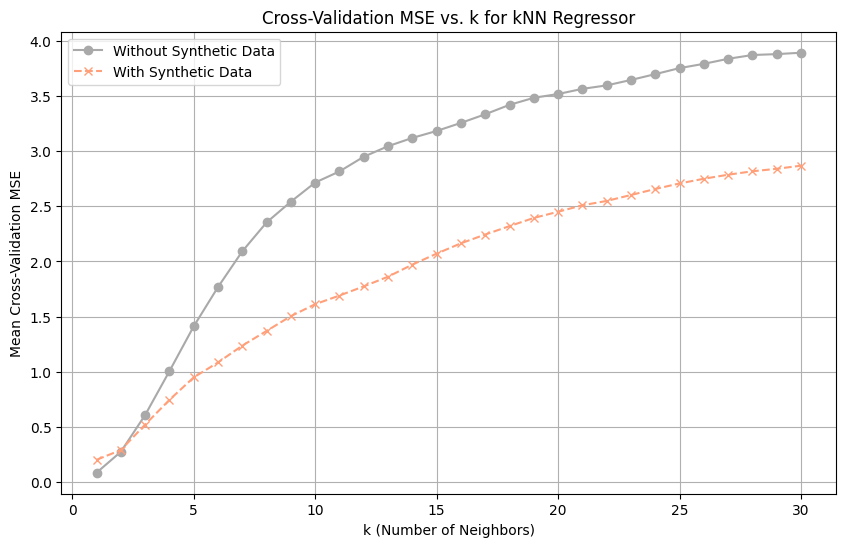

In [29]:
# Plot Cross-Validation MSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values_orig, marker='o', linestyle='-', label='Without Synthetic Data', color='darkgray')
plt.plot(k_values, mse_values_aug, marker='x', linestyle='--', label='With Synthetic Data', color='#FFA07A')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Cross-Validation MSE')
plt.title('Cross-Validation MSE vs. k for kNN Regressor')
plt.legend()
plt.grid()
plt.show()



In [30]:
# Train and predict with the optimal k for original data
knn_reg_orig = KNeighborsRegressor(n_neighbors=best_k_orig)
knn_reg_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = knn_reg_orig.predict(X_test)

# Train and predict with the optimal k for augmented data
knn_reg_aug = KNeighborsRegressor(n_neighbors=best_k_aug)
knn_reg_aug.fit(X_train_aug, y_train_aug)
y_pred_aug = knn_reg_aug.predict(X_test)

# Calculate MSE and accuracy
mse_orig = mean_squared_error(y_test, y_pred_orig)
mse_aug = mean_squared_error(y_test, y_pred_aug)

In [31]:
# Print results
print(f"Mean Squared Error without augmentation: {mse_orig:.2f}")
print(f"Mean Squared Error with augmentation: {mse_aug:.2f}")

Mean Squared Error without augmentation: 7.44
Mean Squared Error with augmentation: 5.05


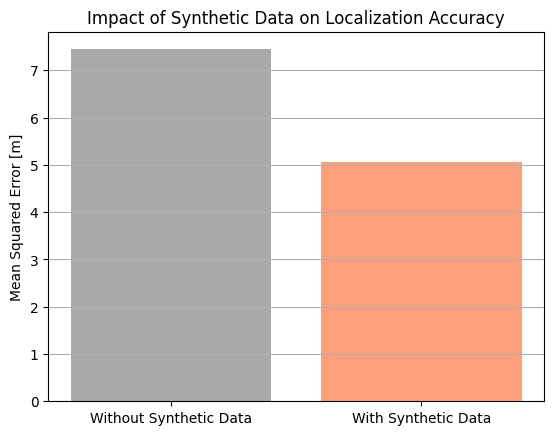

In [32]:
# Accuracy comparison
import matplotlib.pyplot as plt

# Visualize the improvement
plt.bar(['Without Synthetic Data', 'With Synthetic Data'], [mse_orig, mse_aug], color=['darkgray', '#FFA07A'])
plt.ylabel('Mean Squared Error [m]')
plt.title('Impact of Synthetic Data on Localization Accuracy')
plt.grid(axis='y')
plt.show()


In [33]:
# Define a threshold distance for "accuracy"
threshold = 0.5  # in meters

# Calculate distances between predicted and true coordinates (x, y, z only)
distances_orig = np.sqrt(np.sum((y_test[:, :3] - y_pred_orig[:, :3])**2, axis=1))
distances_aug = np.sqrt(np.sum((y_test[:, :3] - y_pred_aug[:, :3])**2, axis=1))

# Calculate accuracy as the percentage of predictions within the threshold
accuracy_orig = np.mean(distances_orig <= threshold) * 100
accuracy_aug = np.mean(distances_aug <= threshold) * 100

# Print results
print(f"Accuracy without augmentation (within {threshold}m): {accuracy_orig:.2f}%")
print(f"Accuracy with augmentation (within {threshold}m): {accuracy_aug:.2f}%")


Accuracy without augmentation (within 0.5m): 2.01%
Accuracy with augmentation (within 0.5m): 1.72%


In [34]:
print("Established parameters")
print("Distance of the VRP created in the grid: ",resolution)
print("Number of neighbors for the GPR: ",k_neighbors)

print("Linear interpolation")
print(f"Generated VRPs: {vrp_points_count}")
print(f"Increment in RPs: {increment_percentage:.2f}%")
print(f"Total RPs (Original + VRPs): {original_points_count + vrp_points_count:.2f}")

print("Localization")
print(f"Optimal k for augmented data: {best_k_aug}")
print(f"Optimal k for original data: {best_k_orig}")
print(f"Mean Squared Error without augmentation: {mse_orig:.2f}")
print(f"Mean Squared Error with augmentation: {mse_aug:.2f}")

percentage_improvement = ((mse_orig - mse_aug) / mse_orig) * 100
print(f"Percentage improvement with augmentation: {percentage_improvement:.2f}%")

Established parameters
Distance of the VRP created in the grid:  2
Number of neighbors for the GPR:  40
Linear interpolation
Generated VRPs: 252
Increment in RPs: 18.41%
Total RPs (Original + VRPs): 1621.00
Localization
Optimal k for augmented data: 1
Optimal k for original data: 1
Mean Squared Error without augmentation: 7.44
Mean Squared Error with augmentation: 5.05
Percentage improvement with augmentation: 32.16%


In [35]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")


Total execution time: 240.95 seconds
